In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

pd.set_option('display.max_columns', 1000, 'display.max_colwidth', 1000, 'display.max_rows',1000)
import warnings
warnings.filterwarnings('ignore')

# Stocks

In [31]:
def convert_date(x,h, m):
    x = str.split(x,sep='-')
    x = [int(item) for item in x]
    date = datetime(year=x[0],month=x[1],day=x[2],hour=h, minute=m, second=0)
    return date

def stockDirection(x, pct=10):
     # increase is 2, decrease is 0, remaining constant (+-pct) is 1
    if x<=-pct:
        return 0
    elif x>=pct:
        return 2
    else:
        return 1

def read_stocks_data_header(filename,read_lines=3):
    # Stocks Data is in UTC

    #generate header from the file
    with open(filename) as myfile:
        head1 =[]
        for i in range (0,read_lines):
            head1.append([str.split(next(myfile).strip(),sep=',') for x in range(0,1)])

    line1 = head1[0][0]
    line2 = head1[1][0]
    line3 = head1[2][0]

    header = [j.replace('^','')+' '+i+k for i, j,k in zip(line1, line2, line3)]
    header = [item.replace(' ','') for item in header]

    return header

def stock_direction(df,pp):
    cols = list(df.columns)
    print(cols)
    cols = [i for i in cols if 'date' not in str.lower(i)]
    for col in cols:
        if str.lower(pp)=='open':
            col_r = str(col).replace('Open','Delta')
        elif str.lower(pp)=='close':
            col_r = str(col).replace('Close','Delta')
        df[col_r] = df[col].dropna().diff()/df[col].dropna().shift(-1)*100

        if str.lower(pp)=='open':
            col_rr = str(col).replace('Open','Direction',)
        elif str.lower(pp)=='close':
            col_rr = str(col).replace('Close','Direction')
        df[col_rr] = df[col_r].dropna().apply(lambda row: stockDirection(row, 0.5))
    return df

def read_stocks_data(filename,header,skiprows):
    df = pd.read_csv(filename,names=header,skiprows=3)
    df['Date']=pd.to_datetime(df.Datetime)
    df['Date']=df.Date.apply(lambda row:row.replace(tzinfo=None))
    
    colofinterest= ['Date']+[col for col in df.columns if 'Open' in col] + [col for col in df.columns if 'Close' in col]
    df=df[colofinterest]
    df.drop_duplicates(subset='Date', inplace=True)

    open_col = ([col for col in df.columns if 'Open' in col])
    open_col.append('Date')
    df_open = df[open_col]

    close_col = [col for col in df.columns if 'Close' in col]
    close_col.append('Date')
    df_close = df[close_col]

    df_open_1 = stock_direction(df_open,pp='open')
    df_close_1 = stock_direction(df_close,pp='close')
    return df_open_1, df_close_1

In [32]:
# Stocks Data
filename='data/^GSPC CL=F ^IXIC ^GSPTSE TSLA BTC-USD _15m.csv'
header = read_stocks_data_header(filename)
df_stocks_open, df_stocks_close = read_stocks_data(filename,header,3)
df_stocks_open['Date'] = df_stocks_open.Date.apply(lambda row: row-timedelta(hours=5)) #change time to EST
df_stocks_close['Date'] = df_stocks_open.Date.apply(lambda row: row-timedelta(hours=5)) #change time to EST
df_stocks_open.head(100)

['BTC-USDOpen', 'CL=FOpen', 'TSLAOpen', 'GSPCOpen', 'GSPTSEOpen', 'IXICOpen', 'Date']
['BTC-USDAdjClose', 'CL=FAdjClose', 'TSLAAdjClose', 'GSPCAdjClose', 'GSPTSEAdjClose', 'IXICAdjClose', 'BTC-USDClose', 'CL=FClose', 'TSLAClose', 'GSPCClose', 'GSPTSEClose', 'IXICClose', 'Date']


,BTC-USDOpen,CL=FOpen,TSLAOpen,GSPCOpen,GSPTSEOpen,IXICOpen,Date,BTC-USDDelta,BTC-USDDirection,CL=FDelta,CL=FDirection,TSLADelta,TSLADirection,GSPCDelta,GSPCDirection,GSPTSEDelta,GSPTSEDirection,IXICDelta,IXICDirection
0,36714.597656,85.330002,NaN,NaN,NaN,NaN,2022-01-25 20:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,36737.652344,85.269997,NaN,NaN,NaN,NaN,2022-01-25 20:45:00,0.062510,1.0,-0.070387,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,36881.648438,85.250000,NaN,NaN,NaN,NaN,2022-01-25 21:00:00,0.389300,1.0,-0.023424,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,36988.496094,85.370003,NaN,NaN,NaN,NaN,2022-01-25 21:15:00,0.289300,1.0,0.140584,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,36933.144531,85.360001,NaN,NaN,NaN,NaN,2022-01-25 21:30:00,-0.150004,1.0,-0.011730,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,36900.101562,85.269997,NaN,NaN,NaN,NaN,2022-01-25 21:45:00,-0.089631,1.0,-0.105763,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,36865.730469,85.099998,NaN,NaN,NaN,NaN,2022-01-25 22:00:00,-0.092881,1.0,-0.199692,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,37005.496094,85.129997,NaN,NaN,NaN,NaN,2022-01-25 22:15:00,0.376253,1.0,0.035268,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,37146.734375,85.059998,NaN,NaN,NaN,NaN,2022-01-25 22:30:00,0.377916,1.0,-0.082217,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,37372.949219,85.139999,NaN,NaN,NaN,NaN,2022-01-25 22:45:00,0.604491,2.0,0.093877,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Generate a List of Dates

In [33]:
# Date Range
df_date= pd.DataFrame()
df_date['Date'] = pd.bdate_range(start='2022-01-01', end='2022-03-26', freq='min')
df_date

,Date
0,2022-01-01 00:00:00
1,2022-01-01 00:01:00
2,2022-01-01 00:02:00
3,2022-01-01 00:03:00
4,2022-01-01 00:04:00
...,...
120956,2022-03-25 23:56:00
120957,2022-03-25 23:57:00
120958,2022-03-25 23:58:00
120959,2022-03-25 23:59:00


# Tweets Data Processing

## Tweet Read

In [9]:
# To clean up texts
import re
import nltk
# nltk.download() Download nltk data for first time use (download all packages)
import nltk.data
# from nltk.stem.snowball import SnowballStemmer
# stemmer = SnowballStemmer('english')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
# tokenizer = nltk.data.load('nltk:tokenizers/punkt/english.pickle')
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('omw-1.4')


In [11]:
tweets_file = 'data/News_tweets.csv'
df_tweets = pd.read_csv(tweets_file)
df_tweets['Time']=pd.to_datetime(df_tweets.Time)

df_tweets['Time'] = df_tweets.Time.apply(lambda row: row-timedelta(hours=5)) # change time to EST
df_tweets.rename(columns={'Time':'tweet_date'}, inplace = True)

colofinterest = ['tweet_date','Content','RetweetNum','LikeNum','UserHandle']
df_tweets = df_tweets[colofinterest].sort_values(by='tweet_date',ascending=True).reset_index(drop=True)
print(df_tweets.shape)
df_tweets.head()

(20000, 5)


,tweet_date,Content,RetweetNum,LikeNum,UserHandle
0,2021-09-21 07:27:44+00:00,"Moving back to the electoral college system of Labour leadership elections is ""a shameful attack on democracy"" says Labour MP Zarah Sultana\n\n""As socialists and social democrats we should be pushing for more democracy""\n\nhttps://t.co/tVI5xzdLUx #PoliticsLive https://t.co/GaSbWNIOvm",139,431,BBCPolitics
1,2021-09-21 08:09:17+00:00,Ministry of Defence shared more than 250 Afghan interpreters' details on email\n\nhttps://t.co/UCylAeK4u1,10,22,BBCPolitics
2,2021-09-21 08:36:42+00:00,Government strikes deal to kickstart CO2 production following warnings about food shortages\n\nhttps://t.co/RDnP0OreT3,8,22,BBCPolitics
3,2021-09-21 08:43:51+00:00,"PM Boris Johnson rejects calls to scrap the cut to £20 top-up to universal credit, arguing that wages are rising above rate of inflation\n\n""We think the best thing we can do is help people into high-skilled, high wage jobs,"" he tells @BBCLauraK \nhttps://t.co/GHzbIHmMe1",27,94,BBCPolitics
4,2021-09-21 09:11:38+00:00,Third man faces charges for Salisbury Novichok attack\n\nhttps://t.co/AxhRSllaX8,2,15,BBCPolitics


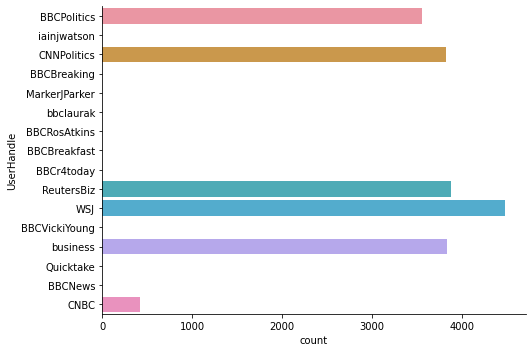

In [12]:
import seaborn as sns
plt = sns.catplot(y='UserHandle', kind='count', data=df_tweets, height=5, aspect=1.5)

## Tweet Cleaning

In [13]:
def sentence_to_wordlist(sentence, remove_stopwords=False):
    # 0. remove mentions(@), Hashtag(#)
    sentence = re.sub(r'@[^\s]+', '', sentence,flags=re.MULTILINE )
    sentence = re.sub(r'#[^\s]+', '', sentence,flags=re.MULTILINE )
    sentence = re.sub(r'RT[^\s]+', '', sentence,flags=re.MULTILINE )
    # 1. drop http
    p1=re.compile(r'http?:\/\/\S+', flags=re.DOTALL)
    sentence = re.sub(p1, '', sentence)
    # 2. drop https
    p1=re.compile(r'https?:\/\/\S+', flags=re.DOTALL)
    sentence = re.sub(p1, '', sentence)
    # 3. Remove non-letters
    sentence = re.sub(r'[^\w\s]','', sentence)
    # 4. Remove all numbers
    sentence = re.sub(r'[0-9]+', '', sentence)
    # 5. Convert words to lower case and split them
    sentence = sentence.lower().split()
    # Remove Stop Words
    # sentence = [word for word in sentence if not word in stop_words]
    # 5. Stemming
    # sentence = [stemmer.stem(w) for w in sentence] 
    # 6. Lemmatizing
    sentence = [lemmatizer.lemmatize(word) for word in sentence]

    #check if returned sentence is blank
    if len(sentence)==0:
      return np.nan
    else:
      # 7. Return a sentence of words
      sentence_r = ''
      for word in sentence:
        sentence_r = sentence_r + ' ' + word
      return(sentence_r)

In [14]:
# create a new column 
df_tweets['Content1']= df_tweets.Content.apply(lambda row: sentence_to_wordlist(row))
df_tweets.dropna(how='any', inplace=True)
df_tweets.reset_index( drop=True, inplace=True,)
df_tweets.head()

,tweet_date,Content,RetweetNum,LikeNum,UserHandle,Content1
0,2021-09-21 07:27:44+00:00,"Moving back to the electoral college system of Labour leadership elections is ""a shameful attack on democracy"" says Labour MP Zarah Sultana\n\n""As socialists and social democrats we should be pushing for more democracy""\n\nhttps://t.co/tVI5xzdLUx #PoliticsLive https://t.co/GaSbWNIOvm",139,431,BBCPolitics,moving back to the electoral college system of labour leadership election is a shameful attack on democracy say labour mp zarah sultana a socialist and social democrat we should be pushing for more democracy
1,2021-09-21 08:09:17+00:00,Ministry of Defence shared more than 250 Afghan interpreters' details on email\n\nhttps://t.co/UCylAeK4u1,10,22,BBCPolitics,ministry of defence shared more than afghan interpreter detail on email
2,2021-09-21 08:36:42+00:00,Government strikes deal to kickstart CO2 production following warnings about food shortages\n\nhttps://t.co/RDnP0OreT3,8,22,BBCPolitics,government strike deal to kickstart co production following warning about food shortage
3,2021-09-21 08:43:51+00:00,"PM Boris Johnson rejects calls to scrap the cut to £20 top-up to universal credit, arguing that wages are rising above rate of inflation\n\n""We think the best thing we can do is help people into high-skilled, high wage jobs,"" he tells @BBCLauraK \nhttps://t.co/GHzbIHmMe1",27,94,BBCPolitics,pm boris johnson reject call to scrap the cut to topup to universal credit arguing that wage are rising above rate of inflation we think the best thing we can do is help people into highskilled high wage job he tell
4,2021-09-21 09:11:38+00:00,Third man faces charges for Salisbury Novichok attack\n\nhttps://t.co/AxhRSllaX8,2,15,BBCPolitics,third man face charge for salisbury novichok attack


In [15]:
# Get US holidays
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2021-06-01', end='2022-12-31').to_pydatetime()
holiday_date = []
for days in holidays:
    holiday_date.append(days.date())

#check weekend or US holiday
def IsHoliday(x,holiday_date):
    # date = x.date()
    weekday = x.weekday()
    if (x in holiday_date) | (weekday==5) | (weekday==6):
        return True #it is holiday
    else:
        return False #it is not holiday

#during market or after market
def IsAfterMkt(x):
    x = x.time()
    starttime = datetime.strptime('9:30:00','%H:%M:%S').time()
    endtime = datetime.strptime('16:00:00','%H:%M:%S').time()
    if ((x >= starttime) & (x<=endtime)):
         return False
    else:
        return True

# Same day or next day
def IsSameDay(x):
    x = x.time()
    samedaystarttime = datetime.strptime('00:00:00','%H:%M:%S').time()
    samedayndtime = datetime.strptime('16:00:00','%H:%M:%S').time()
    if ((x >= samedaystarttime) & (x <= samedayndtime)):
        return True
    else:
        return False


# transform date to correspond to stock market open or close   
def edit_date(x):
    # x = x-timedelta(hours=5)
    date = x.date()
    time = x.time()

    if (IsAfterMkt(x)==True) & (IsSameDay(x)==False):
        time=datetime.strptime('9:30:00','%H:%M:%S').time()
        date=date+timedelta(days=1)
    elif ((IsAfterMkt(x)==True) & (IsSameDay(x)==True)):
        date=date
        time=time=datetime.strptime('9:30:00','%H:%M:%S').time()
    
    while IsHoliday(date,holiday_date) ==1:
        date = date+timedelta(days=1)

    date_time = str(date)+ ' '+ str(time)
    date_time = datetime.strptime(date_time, "%Y-%m-%d %H:%M:%S")
    return date_time

# Code for checking logic
#colofinterest=['tweet_date','tweet_day','Date','Day']
#df_tweets[colofinterest].iloc[85:300]

In [16]:
# Change tweet date to corresponding market open date and time
df_tweets['tweet_day'] = df_tweets.tweet_date.apply(lambda row:row.date().strftime("%A"))
df_tweets['Date'] = df_tweets.tweet_date.apply(lambda row:edit_date(row))
df_tweets['Day'] = df_tweets.Date.apply(lambda row:row.date().strftime("%A"))
df_tweets['Date'] = df_tweets.Date.dt.round('15min') #round to the nearest 15 minute
df_tweets.head(5)

,tweet_date,Content,RetweetNum,LikeNum,UserHandle,Content1,tweet_day,Date,Day
0,2021-09-21 07:27:44+00:00,"Moving back to the electoral college system of Labour leadership elections is ""a shameful attack on democracy"" says Labour MP Zarah Sultana\n\n""As socialists and social democrats we should be pushing for more democracy""\n\nhttps://t.co/tVI5xzdLUx #PoliticsLive https://t.co/GaSbWNIOvm",139,431,BBCPolitics,moving back to the electoral college system of labour leadership election is a shameful attack on democracy say labour mp zarah sultana a socialist and social democrat we should be pushing for more democracy,Tuesday,2021-09-21 09:30:00,Tuesday
1,2021-09-21 08:09:17+00:00,Ministry of Defence shared more than 250 Afghan interpreters' details on email\n\nhttps://t.co/UCylAeK4u1,10,22,BBCPolitics,ministry of defence shared more than afghan interpreter detail on email,Tuesday,2021-09-21 09:30:00,Tuesday
2,2021-09-21 08:36:42+00:00,Government strikes deal to kickstart CO2 production following warnings about food shortages\n\nhttps://t.co/RDnP0OreT3,8,22,BBCPolitics,government strike deal to kickstart co production following warning about food shortage,Tuesday,2021-09-21 09:30:00,Tuesday
3,2021-09-21 08:43:51+00:00,"PM Boris Johnson rejects calls to scrap the cut to £20 top-up to universal credit, arguing that wages are rising above rate of inflation\n\n""We think the best thing we can do is help people into high-skilled, high wage jobs,"" he tells @BBCLauraK \nhttps://t.co/GHzbIHmMe1",27,94,BBCPolitics,pm boris johnson reject call to scrap the cut to topup to universal credit arguing that wage are rising above rate of inflation we think the best thing we can do is help people into highskilled high wage job he tell,Tuesday,2021-09-21 09:30:00,Tuesday
4,2021-09-21 09:11:38+00:00,Third man faces charges for Salisbury Novichok attack\n\nhttps://t.co/AxhRSllaX8,2,15,BBCPolitics,third man face charge for salisbury novichok attack,Tuesday,2021-09-21 09:30:00,Tuesday


In [17]:
# create a new column 
import swifter
df_tweets['Content1']= df_tweets.Content.apply(lambda row: sentence_to_wordlist(row))
df_tweets.dropna(how='any', inplace=True)
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19995 entries, 0 to 19994
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   tweet_date  19995 non-null  datetime64[ns, UTC]
 1   Content     19995 non-null  object             
 2   RetweetNum  19995 non-null  int64              
 3   LikeNum     19995 non-null  int64              
 4   UserHandle  19995 non-null  object             
 5   Content1    19995 non-null  object             
 6   tweet_day   19995 non-null  object             
 7   Date        19995 non-null  datetime64[ns]     
 8   Day         19995 non-null  object             
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), int64(2), object(5)
memory usage: 1.4+ MB


# Tweet Sentiments

In [18]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon', quiet=True)

def polarityScore(a, col):
    # Create a column for score
    a['score'] = a[col].apply(lambda row: calculate_polarity_scores(row))
    #split all the scores into separate columns
    # columns = ['negative', 'neutral', 'positive', 'compound'])
    a['negative']=a.score.apply(lambda x: x[0])
    a['neutral']=a.score.apply(lambda x: x[1])
    a['positive']=a.score.apply(lambda x: x[2])
    a['combined']=a.score.apply(lambda x: x[3])
    return a

def calculate_polarity_scores(x):
    sid = SentimentIntensityAnalyzer()
    score = sid.polarity_scores(x)
    score_list = []
    for i in score.values():
        score_list.append(i)
    return score_list

In [19]:
df_tweets = polarityScore(df_tweets, 'Content1')
# sns.histplot(data=result, x='compound')
df_tweets.head()

,tweet_date,Content,RetweetNum,LikeNum,UserHandle,Content1,tweet_day,Date,Day,score,negative,neutral,positive,combined
0,2021-09-21 07:27:44+00:00,"Moving back to the electoral college system of Labour leadership elections is ""a shameful attack on democracy"" says Labour MP Zarah Sultana\n\n""As socialists and social democrats we should be pushing for more democracy""\n\nhttps://t.co/tVI5xzdLUx #PoliticsLive https://t.co/GaSbWNIOvm",139,431,BBCPolitics,moving back to the electoral college system of labour leadership election is a shameful attack on democracy say labour mp zarah sultana a socialist and social democrat we should be pushing for more democracy,Tuesday,2021-09-21 09:30:00,Tuesday,"[0.174, 0.826, 0.0, -0.743]",0.174,0.826,0.000,-0.7430
1,2021-09-21 08:09:17+00:00,Ministry of Defence shared more than 250 Afghan interpreters' details on email\n\nhttps://t.co/UCylAeK4u1,10,22,BBCPolitics,ministry of defence shared more than afghan interpreter detail on email,Tuesday,2021-09-21 09:30:00,Tuesday,"[0.0, 0.703, 0.297, 0.4215]",0.000,0.703,0.297,0.4215
2,2021-09-21 08:36:42+00:00,Government strikes deal to kickstart CO2 production following warnings about food shortages\n\nhttps://t.co/RDnP0OreT3,8,22,BBCPolitics,government strike deal to kickstart co production following warning about food shortage,Tuesday,2021-09-21 09:30:00,Tuesday,"[0.396, 0.604, 0.0, -0.5994]",0.396,0.604,0.000,-0.5994
3,2021-09-21 08:43:51+00:00,"PM Boris Johnson rejects calls to scrap the cut to £20 top-up to universal credit, arguing that wages are rising above rate of inflation\n\n""We think the best thing we can do is help people into high-skilled, high wage jobs,"" he tells @BBCLauraK \nhttps://t.co/GHzbIHmMe1",27,94,BBCPolitics,pm boris johnson reject call to scrap the cut to topup to universal credit arguing that wage are rising above rate of inflation we think the best thing we can do is help people into highskilled high wage job he tell,Tuesday,2021-09-21 09:30:00,Tuesday,"[0.149, 0.669, 0.182, 0.4019]",0.149,0.669,0.182,0.4019
4,2021-09-21 09:11:38+00:00,Third man faces charges for Salisbury Novichok attack\n\nhttps://t.co/AxhRSllaX8,2,15,BBCPolitics,third man face charge for salisbury novichok attack,Tuesday,2021-09-21 09:30:00,Tuesday,"[0.307, 0.693, 0.0, -0.4767]",0.307,0.693,0.000,-0.4767


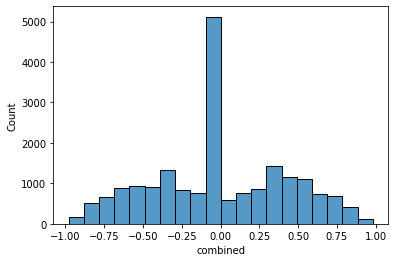

In [20]:
import seaborn as sns
plt = sns.histplot(data=df_tweets, x='combined',bins=20)

# Merge

In [21]:
df = pd.merge(df_date,df_stocks_open,how='inner', on='Date')
df = pd.merge(df, df_tweets, how='inner', on='Date')
#df = df.dropna().reset_index(drop=True)
df

,Date,BTC-USDOpen,CL=FOpen,TSLAOpen,GSPCOpen,GSPTSEOpen,IXICOpen,BTC-USDDelta,BTC-USDDirection,CL=FDelta,CL=FDirection,TSLADelta,TSLADirection,GSPCDelta,GSPCDirection,GSPTSEDelta,GSPTSEDirection,IXICDelta,IXICDirection,tweet_date,Content,RetweetNum,LikeNum,UserHandle,Content1,tweet_day,Day,score,negative,neutral,positive,combined
0,2022-01-26 09:30:00,38421.363281,86.430000,952.429993,4408.430176,20781.300781,13868.869141,60.519531,2.0,-0.089996,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-25 16:33:05+00:00,"Texas went from having 12 competitive US House districts to just one, thanks to gerrymandering. Now, Congress will likely become even more polarized https://t.co/IHZbZumhVy",41,84,CNNPolitics,texas went from having competitive u house district to just one thanks to gerrymandering now congress will likely become even more polarized,Tuesday,Wednesday,"[0.0, 0.805, 0.195, 0.5574]",0.000,0.805,0.195,0.5574
1,2022-01-26 09:30:00,38421.363281,86.430000,952.429993,4408.430176,20781.300781,13868.869141,60.519531,2.0,-0.089996,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-25 17:05:08+00:00,The Cleveland suburbs offer a window into how pandemic policies could shape the midterm elections https://t.co/eYwW6sfw5f,3,12,CNNPolitics,the cleveland suburb offer a window into how pandemic policy could shape the midterm election,Tuesday,Wednesday,"[0.0, 1.0, 0.0, 0.0]",0.000,1.000,0.000,0.0000
2,2022-01-26 09:30:00,38421.363281,86.430000,952.429993,4408.430176,20781.300781,13868.869141,60.519531,2.0,-0.089996,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-25 17:17:02+00:00,"Join us Wednesday, January 26 at 2 p.m. EST to talk Russia and the Biden administration with @kylieatwood, @mchancecnn, @MarquardtA and @jimsciutto.\n\nRSVP for Citizen by CNN here: https://t.co/BfuXgXQ1ZS https://t.co/x1kOVPuC3Z",9,22,CNNPolitics,join u wednesday january at pm est to talk russia and the biden administration with and rsvp for citizen by cnn here,Tuesday,Wednesday,"[0.0, 0.901, 0.099, 0.296]",0.000,0.901,0.099,0.2960
3,2022-01-26 09:30:00,38421.363281,86.430000,952.429993,4408.430176,20781.300781,13868.869141,60.519531,2.0,-0.089996,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-25 17:30:27+00:00,House Speaker Nancy Pelosi announces she will run for reelection for her seat in Congress https://t.co/Fvv4mR0ZNL,286,1834,CNNPolitics,house speaker nancy pelosi announces she will run for reelection for her seat in congress,Tuesday,Wednesday,"[0.0, 1.0, 0.0, 0.0]",0.000,1.000,0.000,0.0000
4,2022-01-26 09:30:00,38421.363281,86.430000,952.429993,4408.430176,20781.300781,13868.869141,60.519531,2.0,-0.089996,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-26 01:44:15+00:00,Boris Johnson to face MPs in Commons as Gray report looms https://t.co/4fErWNlv8i,6,33,BBCPolitics,boris johnson to face mp in common a gray report loom,Wednesday,Wednesday,"[0.174, 0.826, 0.0, -0.2263]",0.174,0.826,0.000,-0.2263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14324,2022-03-25 15:45:00,44493.480469,112.629997,NaN,NaN,NaN,NaN,31.722656,2.0,0.009995,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-25 15:45:11+00:00,"Now that Americans can protect themselves with COVID vaccines, insurance companies are requiring patients to bear more costs for COVID care, and many 'don't have enough money to pay,' said Krutika Amin, associate director at the Kaiser Family Foundation https://t.co/Uggwr2K5pr https://t.co/8jQp6Ero2y",2,8,ReutersBiz,now that american can protect themselves with covid vaccine insurance company are requiring patient to bear more cost for covid care and many dont have enough money to pay said krutika amin associate director at the kaiser family foundation,Friday,Friday,"[0.032, 0.833, 0.134, 0.6597]",0.032,0.833,0.134,0.6597
14325,2022-03-25 15:45:00,44493.480469,112.629997,NaN,NaN,NaN,NaN,31.722656,2.0,0.009995,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-03-25 15:45:41+00:00,Rent prices keep rising—here are the 2

# EDA

In [ ]:
sns.histplot(data=df, x='CL=FDirection',bins=3)

In [ ]:
df.groupby(['CL=FDirection'], as_index=False).agg(
    {
        'combined':['count','mean','var'],
        'negative':['count','mean','var'],
        'neutral':['count','mean','var'],
        'positive':['count','mean','var'],
    }
)

In [ ]:
sns.histplot(data=df, x='GSPCDirection',bins=3)

In [ ]:
df.groupby(['GSPCDirection'], as_index=False).agg(
    {
        'combined':['count','mean','var'],
        'negative':['count','mean','var'],
        'neutral':['count','mean','var'],
        'positive':['count','mean','var'],
    }
)

In [ ]:
sns.histplot(data=df, x='GSPTSEDirection',bins=3)

In [ ]:
df.groupby(['GSPTSEDirection'], as_index=False).agg(
    {
        'combined':['count','mean','var'],
        'negative':['count','mean','var'],
        'neutral':['count','mean','var'],
        'positive':['count','mean','var'],
    }
)

In [ ]:
sns.histplot(data=df, x='IXICDirection',bins=3)

In [ ]:
df.groupby(['IXICDirection'], as_index=False).agg(
    {
        'combined':['count','mean','var'],
        'negative':['count','mean','var'],
        'neutral':['count','mean','var'],
        'positive':['count','mean','var'],
    }
)

# Last Step - Export Data

In [23]:
df.columns

Index(['Date', 'BTC-USDOpen', 'CL=FOpen', 'TSLAOpen', 'GSPCOpen', 'GSPTSEOpen',
       'IXICOpen', 'BTC-USDDelta', 'BTC-USDDirection', 'CL=FDelta',
       'CL=FDirection', 'TSLADelta', 'TSLADirection', 'GSPCDelta',
       'GSPCDirection', 'GSPTSEDelta', 'GSPTSEDirection', 'IXICDelta',
       'IXICDirection', 'tweet_date', 'Content', 'RetweetNum', 'LikeNum',
       'UserHandle', 'Content1', 'tweet_day', 'Day', 'score', 'negative',
       'neutral', 'positive', 'combined'],
      dtype='object')

In [24]:
df.groupby(['Date'], as_index=False).agg(
    {
        'combined':['count','mean','var'],
        'negative':['count','mean','var'],
        'neutral':['count','mean','var'],
        'positive':['count','mean','var'],
        'CL=FDirection':['mean'],
        'GSPCDirection':['mean'],
        'GSPTSEDirection':['mean'],
        'IXICDirection':['mean'],
        'BTC-USDDirection':['mean'],
        'TSLADirection':['mean'],
    }
).reset_index(drop=True).to_csv('data/news_tweets_sentiments.csv',index=False, header=True)

In [25]:
df.groupby(['Date'])[['combined','negative','neutral','positive','CL=FDirection','GSPCDirection','GSPTSEDirection','IXICDirection']]\
    .mean().reset_index(drop=True)

    # .to_csv('data/finaldata.csv',index=False, header=True)

,combined,negative,neutral,positive,CL=FDirection,GSPCDirection,GSPTSEDirection,IXICDirection
0,-0.086669,0.097171,0.826114,0.076771,0.0,NaN,NaN,NaN
1,0.340000,0.000000,0.833000,0.167000,2.0,0.0,0.0,0.0
2,-0.812600,0.346000,0.654000,0.000000,2.0,2.0,2.0,2.0
3,0.025800,0.092000,0.813000,0.095000,0.0,0.0,0.0,0.0
4,-0.440400,0.225000,0.775000,0.000000,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...
1064,0.117475,0.128875,0.684625,0.186500,0.0,2.0,2.0,2.0
1065,-0.210880,0.067800,0.917200,0.015000,0.0,NaN,NaN,NaN
1066,-0.065575,0.076667,0.858333,0.065000,0.0,NaN,NaN,NaN
1067,0.134460,0.055100,0.844500,0.100300,2.0,NaN,NaN,NaN


In [ ]:
df.groupby(['Date'])[['combined','negative','neutral','positive','inc/dec']].mean().reset_index(drop=True)

In [ ]:
df[['Date','Content','Content1','combined','negative','neutral','positive','inc/dec']].to_csv('data/results.csv',index=False, sep=',')